
![D.lensalot logo](./../../res/dlensalot2.PNG)

# Interactive minimal working example - masked sky
In this notebook you perfrom QE and iterative lensing reconstruction for a single simulation, and for a masked sky.
The simulations are created upon runtime inclusive of isotropic white noise and without foregrounds, using a built-in CMB-simulations module.

We generate a simple mask leaving us with a sky fraction of about 17 percent.
Masked data for iterative lensing reconstruction results in a large, so called mean-field, and biases the lensing potential estimate.
To remove this bias, you will estimate the mean-field from a set of simulations.

We will use an isotropic noise model and ignore that the data is masked when we deproject the B-modes.
This is an approximation, and it were better to use the `build_OBD` job to create a better noise model.
However, this is out of scope for this tutorial.

At the end of this tutorial, you will plot the mean-field subtracted lensing potential estimate and obtain delensed power spectra to calculate the residual lensing amplitude.

The configuration file is [here](https://github.com/NextGenCMB/D.lensalot/blob/sv3.1/lenscarf/ana/config/examples/mwe/conf_mwe_fullsky.py), and you can freely change the parameters to your liking. In this configuration file, there are a few objects:

 * `DLENSALOT_Analysis` collects all configurations for the analysis of the data/simulations
 * `DLENSALOT_Data` configures the data which is used. In this minimal working example, we generate the simulation data on the fly and therefore need to choose the simulation module and a few parameters for this
 * `DLENSALOT_Noisemodel` configures the noise model with which the Wiener-filtering is done. 
 * `DLENSALOT_Qerec` and `DLENSALOT_Itrec` are lensing reconstruction specific settings.


In [1]:
import os
from os.path import join as opj
import numpy as np
import healpy as hp

import matplotlib.pyplot as plt

import lenscarf
from lenscarf.run import run

from lenscarf.lerepi.visalot import plot_helper as ph

bpl, bpu = (5,200)
def scale_and_bandpass(data):
    return ph.bandpass_alms(hp.almxfl(data,np.sqrt(ll*(ll+1))), bpl, bpu)

cond4mpi does not exists
could not setup healpix hack. reverting to standard healpy
MSC: using scarf with 2 OMP threads


# Create mask
Any mask will do as long as the remaining sky fraction is large enough to calculate an unbinned power spectrum of the residual maps later

fsky: 0.583


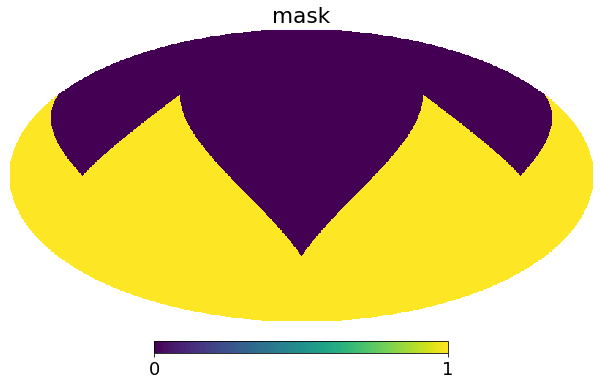

In [2]:
m = np.zeros(hp.nside2npix(1))
m[[5,6,7,8,9,10,11]] = 1
m = hp.ud_grade(m, nside_out=512)
hp.mollview(m, nest=False, title='mask')
print('fsky: {:.3f}'.format(np.mean(m)))

mask_fn = opj(os.environ['SCRATCH'], 'dlensalot/lenscarf/generic/sims_cmb_len_lminB30_my_first_dlensalot_analysis_maskedsky/mask.fits')
if not os.path.isdir(os.path.dirname(mask_fn)):
    os.makedirs(os.path.dirname(mask_fn))
if not os.path.isfile(mask_fn):
    hp.write_map(mask_fn, m)
    print('mask stored at {}'.format(mask_fn))

# QE lensing reconstruction
The following cell,
 
 * line 1: selects the [configuration file](https://github.com/NextGenCMB/D.lensalot/blob/sv3.1/lenscarf/ana/config/examples/mwe/conf_mwe_maskedsky.py) ,
 * line 2: initialises D.lensalot for a QE lensing reconstruction job (`job_id`),
 * line 3: perfroms lensing reconstruction and calculates both, the lensing potential, and the B-lensing template.


When run for the first time, `.run()` generates CMB simulations and stores them as defined in the `DLENSALOT_data.class_parameters.lib_dir` parameter (check out the configuration file). If this path is not convenient, please choose one that works for you.

This cell will take a while as it also calculates the QE mean-field. This is needed, as the masking of the data induces a strong bias in the low-ell lensing potential.
For QE, once the mean-field is calculated, it is subtracted from the QE lensing potential estimate to remove this bias.
This QE estimate is then used as a starting point for the iterative lensing reconstruction

In [4]:
fn = opj(os.path.dirname(os.path.abspath(lenscarf.__file__)),'ana/config/examples/mwe/conf_mwe_maskedsky.py')
ana_mwe = run(config=fn, job_id='QE_lensrec', verbose=False).job
# ana_mwe.run()

## Check QE results

`get_plm` and `get_meanfield_normalized` returns the normalized lensing potential and mean-field.
Let us plot it to see if they look as expected

In [5]:
ll = np.arange(0,ana_mwe.qe_lm_max_qlm[0]+1,1)
scale_factor = (ll*(ll+1))**2/(2*np.pi)
mask = hp.read_map(ana_mwe.mask_fn)

mf_QE = ana_mwe.get_meanfield_normalized(0)
plm_QE = ana_mwe.get_plm(0, [0])

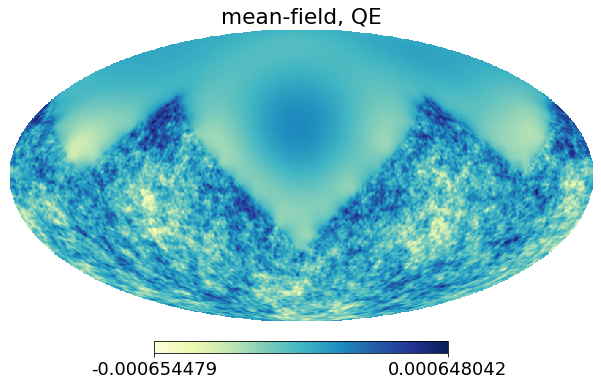

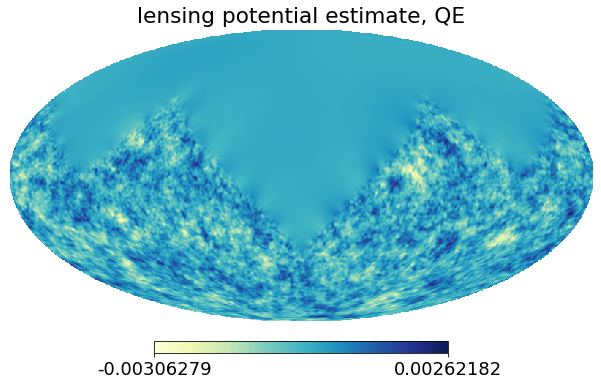

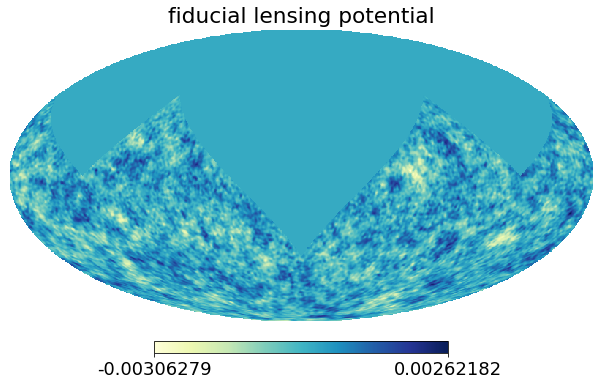

In [12]:
hp.mollview(hp.alm2map(scale_and_bandpass(mf_QE), nside=512), title='mean-field, QE', cmap='YlGnBu')
hp.mollview(hp.alm2map(scale_and_bandpass(plm_QE), nside=512), title='lensing potential estimate, QE', cmap='YlGnBu')
hp.mollview(mask*hp.alm2map(scale_and_bandpass(plm_QE), nside=512), cmap='YlGnBu', title='fiducial lensing potential')

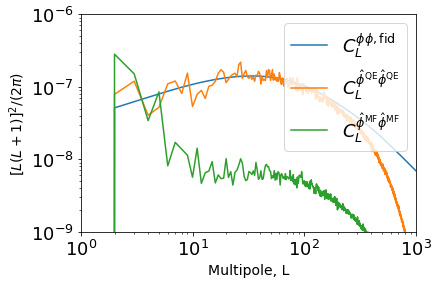

In [13]:
plt.plot(scale_factor*ana_mwe.cpp, label=r'$C_L^{\phi\phi,{\rm fid}}$')
plt.plot(scale_factor*hp.alm2cl(plm_QE)/np.mean(mask), label=r'$C_L^{\hat{\phi}^{\rm QE}\hat{\phi}^{\rm QE}}$')

plt.plot(scale_factor*hp.alm2cl(mf_QE)/np.mean(mask), label=r'$C_L^{\hat{\phi}^{\rm MF}\hat{\phi}^{\rm MF}}$')

plt.legend(fontsize=18, loc='upper right')
plt.xlabel('Multipole, L', fontsize=14)
plt.ylabel(r'$\left[L(L+1)\right]^2/(2\pi)$', fontsize=14)
plt.xscale('log')
plt.xlim(1,1e3)
plt.ylim(1e-9,1e-6)
plt.yscale('log')

# iterative lensing reconstruction

The following cell repeats above, but for the iterative case.
For the iterations, we use a fast Wiener-filtering, allowing us to get fast iterative results in an idealized setting.

(We could have skipped above cell entirely. As iterative lensing reconstruction depends on a QE starting point, Dlensalot would have known to run `QE_lensrec` first.)

In [ ]:
fn = opj(os.path.dirname(os.path.abspath(lenscarf.__file__)),'ana/config/examples/mwe/conf_mwe_maskedsky.py')
ana_mwe = run(config=fn, job_id='MAP_lensrec', verbose=True).job
ana_mwe.run()

INFO:: 02-06 14:45:: lenscarf.lerepi.core.handler.log - load_configfile() Started: /global/u2/s/sebibel/git/lenscarf/lenscarf/ana/config/examples/mwe/conf_mwe_maskedsky.py
INFO:: 02-06 14:45:: lenscarf.lerepi.core.handler.log - load_configfile() Finished
INFO:: 02-06 14:45:: lenscarf.lerepi.core.handler.log - store() Started
INFO:: 02-06 14:45:: lenscarf.lerepi.core.handler.log - load_configfile() Started: /global/cscratch1/sd/sebibel/dlensalot/lenscarf/generic/sims_cmb_len_lminB30_my_first_dlensalot_analysis_maskedsky/conf_mwe_maskedsky.py
INFO:: 02-06 14:45:: lenscarf.lerepi.core.handler.log - load_configfile() Finished
INFO:: 02-06 14:45:: root.store - config file look the same. Resuming where I left off last time.
INFO:: 02-06 14:45:: root.store - Matching config file found. Resuming where I left off.
INFO:: 02-06 14:45:: lenscarf.lerepi.core.handler.log - store() Finished
INFO:: 02-06 14:45:: lenscarf.lerepi.core.handler.log - collect_jobs() Started
INFO:: 02-06 14:45:: lenscarf.l

In [ ]:
import os
from os.path import join as opj
import numpy as np
import healpy as hp

import matplotlib.pyplot as plt

import lenscarf
from lenscarf.run import run

from lenscarf.lerepi.visalot import plot_helper as ph

bpl, bpu = (5,200)
def scale_and_bandpass(data):
    return ph.bandpass_alms(hp.almxfl(data,np.sqrt(ll*(ll+1))), bpl, bpu)

fn = opj(os.path.dirname(os.path.abspath(lenscarf.__file__)),'ana/config/examples/mwe/conf_mwe_maskedsky.py')
ana_mwe = run(config=fn, job_id='MAP_lensrec', verbose=False).job
ana_mwe.run()

cond4mpi does not exists
could not setup healpix hack. reverting to standard healpy
MSC: using scarf with 2 OMP threads
( 512, 1024) [00:01:36] (0, 1.41740100)
( 512, 1024) [00:02:22] (1, 0.09391557)
( 512, 1024) [00:03:03] (2, 0.02209387)
( 512, 1024) [00:03:44] (3, 0.01127569)
( 512, 1024) [00:04:25] (4, 0.00734087)
( 512, 1024) [00:05:06] (5, 0.00600163)
( 512, 1024) [00:05:47] (6, 0.00440521)
( 512, 1024) [00:06:27] (7, 0.00384834)
( 512, 1024) [00:07:08] (8, 0.00338534)
( 512, 1024) [00:07:48] (9, 0.00287783)
( 512, 1024) [00:08:28] (10, 0.00276245)
( 512, 1024) [00:09:08] (11, 0.00251187)
( 512, 1024) [00:09:48] (12, 0.00231385)
( 512, 1024) [00:10:28] (13, 0.00211449)
( 512, 1024) [00:11:09] (14, 0.00185127)
( 512, 1024) [00:11:50] (15, 0.00170789)
( 512, 1024) [00:12:31] (16, 0.00155878)
( 512, 1024) [00:13:11] (17, 0.00145718)
( 512, 1024) [00:13:52] (18, 0.00135577)
( 512, 1024) [00:14:32] (19, 0.00121441)
( 512, 1024) [00:15:14] (20, 0.00111376)
( 512, 1024) [00:15:57] (21, 

# Check your results
## lensing potential and mean-field
After completion of above cells, we can look at the reconstructed lensing potential.
`get_plm_it(idx, its)` returns the spherical harmonics of the lensing potential estimate for simulation `idx` and iteration `its`

In [4]:
ll = np.arange(0,ana_mwe.qe_lm_max_qlm[0]+1,1)
scale_factor = (ll*(ll+1))**2/(2*np.pi)
mask = hp.read_map(ana_mwe.mask_fn)

In [5]:
ana_mwe._sims.nside

512

INFO:: 02-06 14:26:: lenscarf.core.handler.log - get_plm_it(0, [0]) started
INFO:: 02-06 14:26:: lenscarf.core.handler.log - get_plm_it(0, [0]) finished
INFO:: 02-06 14:26:: lenscarf.core.handler.log - get_plm_it(0, [1]) started
INFO:: 02-06 14:26:: lenscarf.core.handler.log - get_plm_it(0, [1]) finished


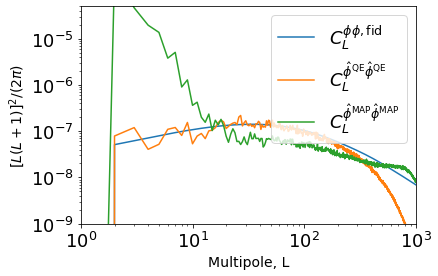

In [6]:
plm_QE = ana_mwe.get_plm_it(0, [0])[0]
plm_MAP = ana_mwe.get_plm_it(0, [1])[0]

plt.plot(scale_factor*ana_mwe.cpp, label=r'$C_L^{\phi\phi,{\rm fid}}$')
plt.plot(scale_factor*hp.alm2cl(plm_QE)/np.mean(mask), label=r'$C_L^{\hat{\phi}^{\rm QE}\hat{\phi}^{\rm QE}}$')
plt.plot(scale_factor*hp.alm2cl(plm_MAP)/np.mean(mask), label=r'$C_L^{\hat{\phi}^{\rm MAP}\hat{\phi}^{\rm MAP}}$')

plt.legend(fontsize=18, loc='upper right')
plt.xlabel('Multipole, L', fontsize=14)
plt.ylabel(r'$\left[L(L+1)\right]^2/(2\pi)$', fontsize=14)
plt.xscale('log')
plt.xlim(1,1e3)
plt.ylim(1e-9,5e-5)
plt.yscale('log')

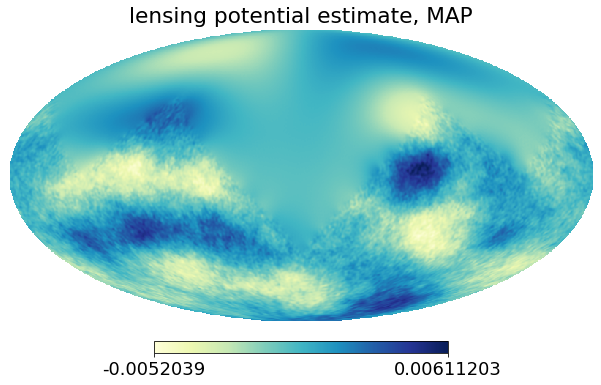

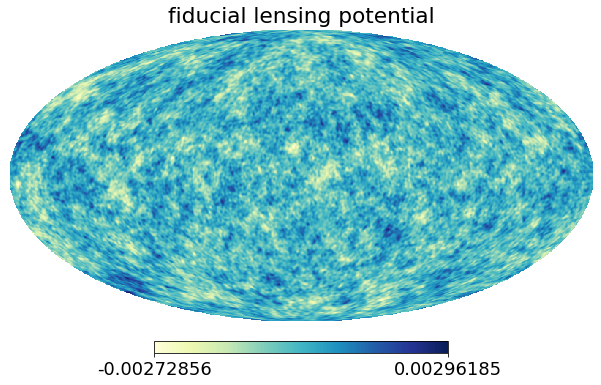

In [7]:
hp.mollview(hp.alm2map(scale_and_bandpass(plm_MAP), nside=2048), cmap='YlGnBu', title='lensing potential estimate, MAP')
hp.mollview(hp.alm2map(scale_and_bandpass(ana_mwe._sims.get_sim_plm(0)), nside=2048), title='fiducial lensing potential', cmap='YlGnBu')
# hp.mollview(hp.alm2map(scale_and_bandpass(plm_MAP-plm_QE), nside=2048), cmap='YlGnBu', title='difference MAP-QE lensing potential estimate')
# hp.mollview(hp.alm2map(scale_and_bandpass(plm_MAP-ana_mwe._sims.get_sim_plm(0)), nside=2048), cmap='YlGnBu', title='difference MAP-fiducial lensing potential estimate')

# Delensed spectrum
For both QE and iterative lensing reconstruction, D.lensalot already calculated the B-lensing templates. You can use them to delens the B-lensing maps and obtain residual maps

In [9]:
input_blensing = hp.map2alm(hp.alm2map(ana_mwe._sims.get_sim_blm(0), nside=2048), lmax=1024)
blt_QE = ana_mwe.get_blt(0, calc=False)
blt_MAP = ana_mwe.get_blt_it(0, 1, calc=False)

INFO:: 02-06 09:10:: lenscarf.core.handler.log - get_blt(0, False) started
INFO:: 02-06 09:10:: lenscarf.core.handler.log - get_wflm(0) started
INFO:: 02-06 09:10:: lenscarf.core.handler.log - get_wflm(0) finished
INFO:: 02-06 09:10:: lenscarf.core.handler.log - get_meanfield(0) started
INFO:: 02-06 09:10:: lenscarf.core.handler.log - get_meanfield(0) finished
INFO:: 02-06 09:10:: lenscarf.core.handler.log - get_plm(0) started
INFO:: 02-06 09:10:: lenscarf.core.handler.log - get_plm(0) finished
INFO:: 02-06 09:10:: lenscarf.remapping.__init__ -  Deflection std 0.00e+00 amin
INFO:: 02-06 09:10:: lenscarf.iterators.iteration_handler.log - get_datmaps() started
INFO:: 02-06 09:10:: lenscarf.iterators.iteration_handler.log - get_datmaps() finished
INFO:: 02-06 09:10:: lenscarf.iterators.iteration_handler.log - get_filter() started
INFO:: 02-06 09:10:: lenscarf.iterators.iteration_handler.log - get_filter_aniso() started
INFO:: 02-06 09:10:: lenscarf.opfilt.opfilt_ee_wl.__init__ - *** alm_f

In [10]:
blens_residual_QE = input_blensing - blt_QE
blens_residual_MAP = input_blensing - blt_MAP

Text(0, 0.5, '$C_\\ell [\\mu $$\\rm{K}^2$]')

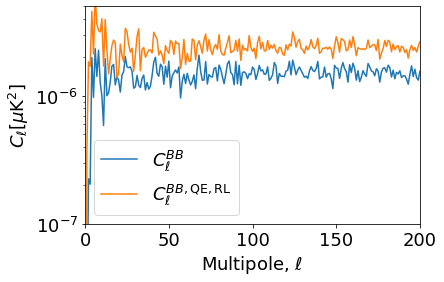

In [12]:
plt.plot(hp.alm2cl(input_blensing, lmax=200), label=r'$C_\ell^{BB}$')
plt.plot(hp.alm2cl(blens_residual_QE, lmax=200)/np.mean(mask), label=r'$C_\ell^{BB,{\rm QE,RL}}$')
plt.plot(hp.alm2cl(blens_residual_MAP, lmax=200), label=r'$C_\ell^{BB,{\rm MAP,RL}}$')

plt.legend()
plt.yscale('log')
plt.xlim(0,200)
plt.ylim(1e-7,5e-6)
plt.xlabel('Multipole, $\ell$')
plt.ylabel('$C_\ell [\mu $'+r'$\rm{K}^2$]')

## residual lensing amplitude $A_{\rm lens}$
A simple estimate of the reduction of lensing power is to take the ratio between the input and resdiual B-lensing signal, averaged across the scales of interest. Here, we simply take the scales about the recombination peak

In [ ]:
print(20*'~.')
print('A_{lens}^{QE}:'+'\t{:.3f}'.format(np.mean((hp.alm2cl(blens_residual_QE, lmax=200)/hp.alm2cl(input_blensing, lmax=200))[30:200])))
print('A_{lens}^{MAP}:'+'\t{:.3f}'.format(np.mean((hp.alm2cl(blens_residual_MAP, lmax=200)/hp.alm2cl(input_blensing, lmax=200))[30:200])))
print(20*'~.')

# Summary and next steps
This tutorial demonstrated the usage of D.lensalot on a masked sky, and you obtained lensing potential estimates and residual lensing amplitudes from simulation data generated upon runtime.

D.lensalot can also perfrom lensing reconstruction on more challenging settings such as,

 * inhomogeneous noise,
 * data inclusive of foreground (residuals).
 
Further, it can calculate reconstruction noise `N0`, and `N1`, and make analytical predictions for the delensed power spectra.
It also has MPI support.
 
Please check out the other tutorials, or see the [documentation](link_to_rtd_doc), or [github](https://github.com/NextGenCMB/D.lensalot) for more.